In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_dir='/kaggle/input/egyptian-hieroglyphs/train/'
val_dir='/kaggle/input/egyptian-hieroglyphs/valid/'
test_dir='/kaggle/input/egyptian-hieroglyphs/test/'

train_df=pd.read_csv('/kaggle/input/egyptian-hieroglyphs/train/_annotations.csv')
val_df=pd.read_csv('/kaggle/input/egyptian-hieroglyphs/valid/_annotations.csv')
test_df=pd.read_csv('/kaggle/input/egyptian-hieroglyphs/test/_annotations.csv')

In [3]:
train_df.head()

filename  width  height  \
0  nile-fish-7-_jpg.rf.31e4278980878c47a1e6a2f8dd...    640     640   
1  Her-8-_jpg.rf.32bcf63f4ae4d6aea53cea5b9c0059b4...    640     640   
2  composite_bow-34-_jpg.rf.33153e63f7158777c50d4...    640     640   
3  snake-6-_jpg.rf.32ac52ece4bcc06b1ead936693df17...    640     640   
4  king-26-_jpg.rf.329a5a8e366f4fe2e3a3dca88524cc...    640     640   

           class  xmin  ymin  xmax  ymax  
0      Nile_Fish   375   319   512   454  
1            Her   211   247   368   339  
2  Composite_Bow   158   183   336   282  
3          Snake   181   351   318   506  
4           King   218   290   339   524

In [4]:
x_train=[]
y_train=[]


files=train_df['filename']

x_min=train_df['xmin']
x_max=train_df['xmax']
y_min=train_df['ymin']
y_max=train_df['ymax']

i=0

for filename in files:
    image=cv2.imread(os.path.join(train_dir,filename))
    cropped_image=image[y_min[i]:y_max[i],x_min[i]:x_max[i]]
    resized_image=cv2.resize(cropped_image,(224,224))
    rgb_image=cv2.cvtColor(resized_image,cv2.COLOR_BGR2RGB)
    x_train.append(rgb_image)
    i+=1

    
y_train=train_df['class']

In [5]:
class_name=list(set(y_train))

In [6]:
print(len(x_train),len(y_train))

2723 2723


In [7]:
rand_idx=list(np.random.randint(0,len(x_train),20))
plt.figure(figsize=(20,20))
cnt=0
for i in rand_idx:
    plt.subplot(5,5,cnt+1)
    plt.imshow(x_train[i])
    plt.title(y_train[i])
    cnt+=1

In [8]:
for i in range(len(x_train)):
    x_train[i]=x_train[i]/255.0

In [9]:
y_train.isnull().sum()

0

In [10]:
x_val=[]
y_val=val_df['class']

files=val_df['filename']

x_min=val_df['xmin']
x_max=val_df['xmax']
y_min=val_df['ymin']
y_max=val_df['ymax']

i=0

for file in files:
    image=cv2.imread(os.path.join(val_dir,file))
    cropped_image=image[y_min[i]:y_max[i],x_min[i]:x_max[i]]
    resized_image=cv2.resize(cropped_image,(224,224))
    rgb_image=cv2.cvtColor(resized_image,cv2.COLOR_BGR2RGB)
    x_val.append(rgb_image)
    i+=1
    

In [11]:
rand_idx=list(np.random.randint(0,len(x_val),20))
plt.figure(figsize=(20,20))
cnt=0
for i in rand_idx:
    plt.subplot(5,5,cnt+1)
    plt.imshow(x_val[i])
    plt.title(y_val[i])
    cnt+=1

In [12]:
for i in range(len(x_val)):
    x_val[i]=x_val[i]/255.0

In [13]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)

In [14]:
x_train=np.array(x_train)
x_train= x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 3)
y_train=np.array(y_train)
x_val=np.array(x_val)
x_val= x_val.reshape(x_val.shape[0], x_val.shape[1], x_val.shape[2], 3)
y_val=np.array(y_val)

In [15]:
from sklearn.utils import shuffle
x_train,y_train = shuffle(x_train,y_train)

In [16]:
print("X_train shape:", x_train.shape)  
print("y_train shape:", y_train.shape)

X_train shape: (2723, 224, 224, 3)
y_train shape: (2723,)


In [17]:
input_shape=(224,224,3)
inputs=tf.keras.Input(shape=input_shape)
base_model_2=tf.keras.applications.EfficientNetV2B3(include_top=False,weights='imagenet',input_tensor=inputs)
base_model_2.trainable=True

var=tf.keras.layers.Flatten()(base_model_2.output)

var=tf.keras.layers.Dense(128,activation='relu')(var)
var=tf.keras.layers.BatchNormalization()(var)
var=tf.keras.layers.Dropout(0.2)(var)

var=tf.keras.layers.Dense(128,activation='relu')(var)
var=tf.keras.layers.BatchNormalization()(var)
var=tf.keras.layers.Dropout(0.2)(var)

var=tf.keras.layers.Dense(128,activation='relu')(var)
var=tf.keras.layers.BatchNormalization()(var)
var=tf.keras.layers.Dropout(0.2)(var)

var=tf.keras.layers.Dense(128,activation='relu')(var)
var=tf.keras.layers.BatchNormalization()(var)
var=tf.keras.layers.Dropout(0.2)(var)

outputs=tf.keras.layers.Dense(95,activation='softmax')(var)

model_2=tf.keras.models.Model(inputs=inputs,outputs=outputs)

opt=tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)

model_2.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['accuracy'])



52606240/52606240 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
model_2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,080 │ normalization[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      5,760 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 112, 112,  │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 112, 112,  │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 112, 112,  │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b

 Total params: 22,628,381 (86.32 MB)

 Trainable params: 22,518,141 (85.90 MB)

 Non-trainable params: 110,240 (430.62 KB)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint

early_stopping=EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)
learning_rate=ReduceLROnPlateau(monitor='val_loss',factor=0.1,min_lr=1e-6,patience=10)
ckeck_points=ModelCheckpoint(filepath='best_model.keras',monitor='val_loss',save_best_only=True,save_weights_only=False)

In [20]:
history_2=model_2.fit(x_train,y_train,epochs=50,batch_size=32,validation_data=(x_val,y_val),callbacks=[early_stopping,learning_rate,ckeck_points],shuffle=True)

Epoch 1/50


I0000 00:00:1732305405.284907      69 service.cc:145] XLA service 0x7df028027600 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732305405.285004      69 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1732305529.320852      69 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_12', 232 bytes spill stores, 236 bytes spill loads

I0000 00:00:1732305529.485447      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


85/86 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.0179 - loss: 4.9966

I0000 00:00:1732305674.269369      69 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion', 36 bytes spill stores, 36 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_421', 36 bytes spill stores, 36 bytes spill loads



86/86 ━━━━━━━━━━━━━━━━━━━━ 340s 2s/step - accuracy: 0.0180 - loss: 4.9926 - val_accuracy: 0.0090 - val_loss: 4.6794 - learning_rate: 0.0010
Epoch 2/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 15s 169ms/step - accuracy: 0.0327 - loss: 4.6530 - val_accuracy: 0.0116 - val_loss: 4.7350 - learning_rate: 0.0010
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 15s 168ms/step - accuracy: 0.1096 - loss: 3.8323 - val_accuracy: 0.0398 - val_loss: 5.4429 - learning_rate: 0.0010
Epoch 4/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 15s 169ms/step - accuracy: 0.1846 - loss: 3.2688 - val_accuracy: 0.0167 - val_loss: 5.8674 - learning_rate: 0.0010
Epoch 5/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 16s 191ms/step - accuracy: 0.1660 - loss: 3.3763 - val_accuracy: 0.1195 - val_loss: 3.8258 - learning_rate: 0.0010
Epoch 6/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 17s 192ms/step - accuracy: 0.2758 - loss: 2.6959 - val_accuracy: 0.2147 - val_loss: 3.4139 - learning_rate: 0.0010
Epoch 7/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 14s 168ms/step - accuracy: 0.4020 - loss: 2.1221 - val_ac

In [21]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(1, len(loss) + 1)

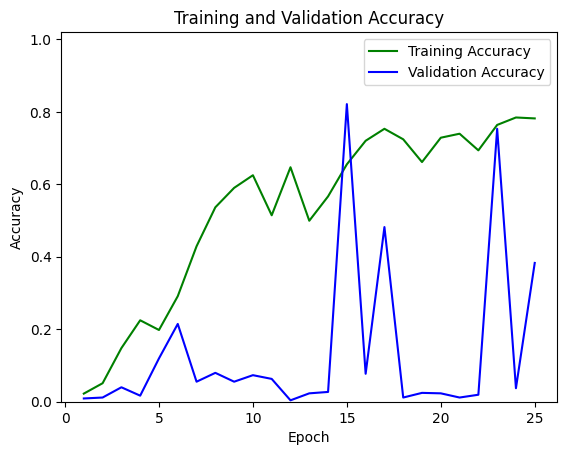

In [22]:
#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim(0,1.02)
plt.show()

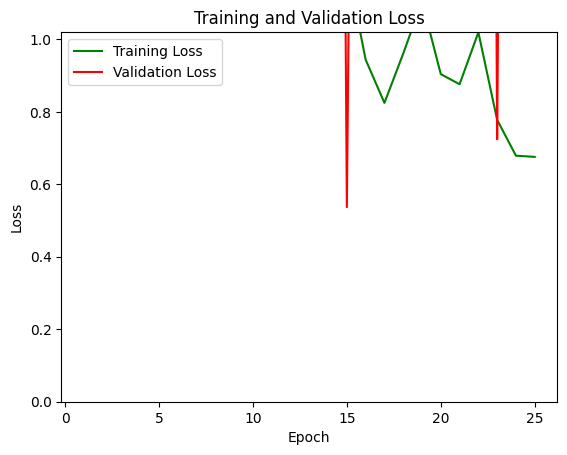

In [23]:
plt.figure()
#loss plot
plt.plot(epochs, loss, color='green', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0,1.02)
plt.show()

In [24]:
# Evaluate the model
model_evaluate = model_2.evaluate(x_train,y_train)
print("Loss     : ",model_evaluate[0])
print("Accuracy : ",model_evaluate[1])

86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.9035 - loss: 0.3573
Loss     :  0.3508095443248749
Accuracy :  0.9019463658332825


In [25]:
# Evaluate the model
model_evaluate = model_2.evaluate(x_val,y_val)
print("Loss     : ",model_evaluate[0])
print("Accuracy : ",model_evaluate[1])

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8187 - loss: 0.5317
Loss     :  0.536922812461853
Accuracy :  0.8213367462158203


In [26]:
x_test=[]
y_test=[]


files=test_df['filename']

x_min=test_df['xmin']
x_max=test_df['xmax']
y_min=test_df['ymin']
y_max=test_df['ymax']

i=0

for filename in files:
    image=cv2.imread(os.path.join(test_dir,filename))
    cropped_image=image[y_min[i]:y_max[i],x_min[i]:x_max[i]]
    resized_image=cv2.resize(cropped_image,(224,224))
    rgb_image=cv2.cvtColor(resized_image,cv2.COLOR_BGR2RGB)
    x_test.append(rgb_image)
    i+=1

    
y_test=test_df['class']

In [27]:
for i in range(len(x_test)):
    x_test[i]=x_test[i]/255.0
    
y_test = label_encoder.transform(y_test)

In [28]:
x_test=np.array(x_test)
x_test= x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 3)
y_test=np.array(y_test)

In [29]:
model_evaluate = model_2.evaluate(x_test,y_test)
print("Loss     : ",model_evaluate[0])
print("Accuracy : ",model_evaluate[1])

13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 439ms/step - accuracy: 0.8471 - loss: 0.4885
Loss     :  0.5178685784339905
Accuracy :  0.8534704446792603


In [30]:
predictions = model_2.predict(x_test)
y_pred = predictions.argmax(axis=-1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 631ms/step


In [31]:
from sklearn.metrics import classification_report
print("Classification report : \n",classification_report(y_test, y_pred))

Classification report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.86      0.75      0.80         8
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         2
           4       1.00      0.83      0.91         6
           5       0.25      0.33      0.29         3
           6       1.00      1.00      1.00         6
           7       0.33      1.00      0.50         1
           8       0.88      1.00      0.93         7
           9       0.88      0.88      0.88         8
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         3
          12       0.25      1.00      0.40         1
          13       1.00      1.00      1.00         1
          14       0.50      0.33      0.40         3
          15       1.00      1.00      1.00         2
          16       1.00      0.50      0.67         2
 